         Date  Commodity Price  Commodity Value  Static Futures Qty  \
0  2025-01-01            70.50          7049.67                -100   
1  2025-01-02            70.36          7035.84                -100   
2  2025-01-03            71.01          7100.61                -100   
3  2025-01-06            72.53          7252.92                -100   
4  2025-01-07            72.30          7229.50                -100   
5  2025-01-08            72.06          7206.09                -100   
6  2025-01-09            73.64          7364.01                -100   
7  2025-01-10            74.41          7440.75                -100   
8  2025-01-13            73.94          7393.81                -100   
9  2025-01-14            74.48          7448.06                -100   
10 2025-01-15            74.02          7401.72                -100   
11 2025-01-16            73.55          7355.15                -100   
12 2025-01-17            73.79          7379.34                -100   
13 202

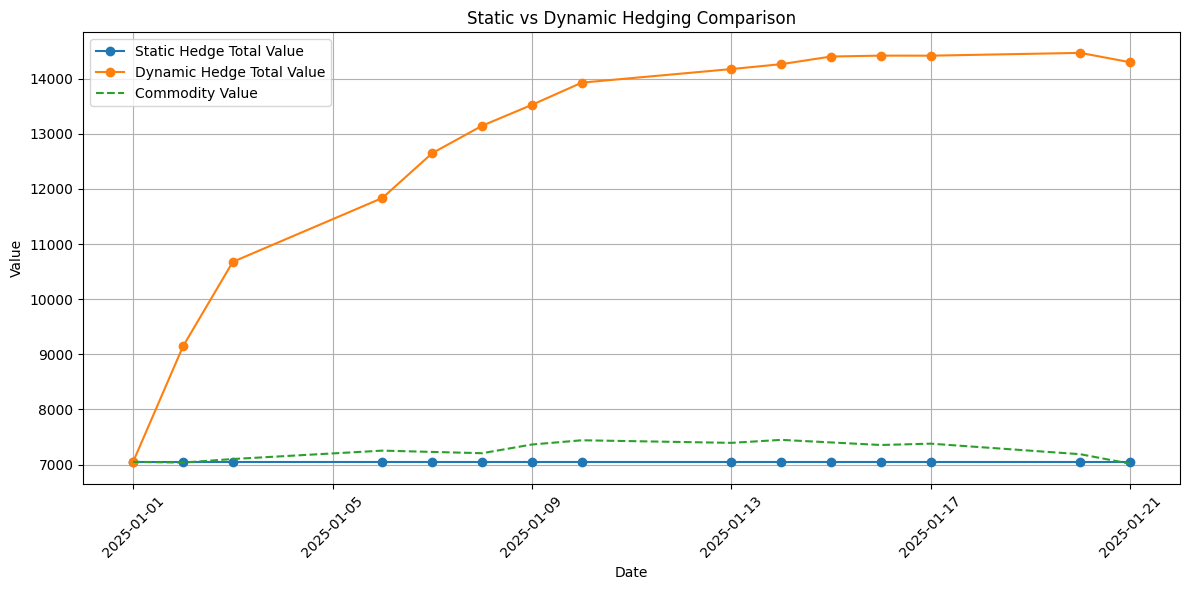

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
np.random.seed(42)
dates = pd.date_range("2025-01-01", periods=15, freq='B')
commodity_price = 70 + np.cumsum(np.random.normal(0, 1, len(dates)))  # random walk
commodity_qty = 100
contract_size = 1
transaction_cost_per_contract = 0.10  # added transaction cost

# Initialize DataFrame
df = pd.DataFrame({
    "Date": dates,
    "Commodity Price": commodity_price
})

# Commodity Value
df["Commodity Value"] = df["Commodity Price"] * commodity_qty

# --- STATIC HEDGE (full hedge from day 0, never changes) ---
static_qty = -commodity_qty  # full hedge
df["Static Futures Qty"] = static_qty
df["Static Futures P&L"] = (df["Commodity Price"] - df["Commodity Price"].iloc[0]) * static_qty
df["Static Cash"] = 0  # assume no incremental cash changes for static hedge
df["Static Total Value"] = df["Commodity Value"] + df["Static Futures P&L"] + df["Static Cash"]

# --- DYNAMIC HEDGE (gradual adjustment) ---
df["Dynamic Futures Qty"] = 0.0
df["Dynamic Futures P&L"] = 0.0
df["Dynamic Cash"] = 0.0
df["Dynamic Total Value"] = 0.0

hedge_ratio = 1.0  # target hedge
adjust_speed = 0.3  # fraction of delta adjusted per day

for i in range(len(df)):
    target_qty = -hedge_ratio * commodity_qty
    if i == 0:
        df.loc[i, "Dynamic Futures Qty"] = 0
        df.loc[i, "Dynamic Cash"] = 0
        df.loc[i, "Dynamic Futures P&L"] = 0
    else:
        prev_qty = df.loc[i-1, "Dynamic Futures Qty"]
        adjust_qty = (target_qty - prev_qty) * adjust_speed
        df.loc[i, "Dynamic Futures Qty"] = prev_qty + adjust_qty

        price_change = df.loc[i, "Commodity Price"] - df.loc[i-1, "Commodity Price"]
        # Using previous day's quantity for P&L calculation
        df.loc[i, "Dynamic Futures P&L"] = price_change * df.loc[i-1, "Dynamic Futures Qty"] * contract_size

        # Include transaction costs for the quantity adjusted
        df.loc[i, "Dynamic Cash"] = df.loc[i-1, "Dynamic Cash"] - adjust_qty * df.loc[i, "Commodity Price"] * contract_size - abs(adjust_qty) * transaction_cost_per_contract

    df.loc[i, "Dynamic Total Value"] = df.loc[i, "Commodity Value"] + df.loc[i, "Dynamic Futures P&L"] + df.loc[i, "Dynamic Cash"]

# --- Display table ---
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(df[[
    "Date", "Commodity Price", "Commodity Value",
    "Static Futures Qty", "Static Futures P&L", "Static Total Value",
    "Dynamic Futures Qty", "Dynamic Futures P&L", "Dynamic Cash", "Dynamic Total Value"
]])

# --- Plot comparison ---
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Static Total Value"], label="Static Hedge Total Value", marker='o')
plt.plot(df["Date"], df["Dynamic Total Value"], label="Dynamic Hedge Total Value", marker='o')
plt.plot(df["Date"], df["Commodity Value"], label="Commodity Value", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Static vs Dynamic Hedging Comparison")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()